In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [2]:
def sun(x, y):
    return 1. * (x**2 + y**2 < 16**2)

In [3]:
def beam(x, y, dx, dy):
    """
    x, y   : position to get the value
    dx, dy : center of the beam
    """
    FWHM = 2.6
    c = FWHM / 2 / np.sqrt(2 * np.log(2))
    a = 1 / 2 / c**2
    return np.exp(-a * ((x-dx)**2 + (y-dy)**2))

In [4]:
def conv_2d(x, y, source, beam):
    """
    x, y : position to get the value
    """
    coord_grid = np.linspace(-5.2, 5.2, 400)
    x_coord = np.array([coord_grid]*400)
    X = x + x_coord
    y_coord = x_coord.T * (-1)
    Y = y + y_coord
    array_source = source(X, Y)
    array_beam = beam(X, Y, x, y) # center of the beam is always current position
    observed = sum(sum(array_source * array_beam))
    return observed

In [5]:
################################
offset_list = [0, 5, 10, 14, 15]
################################

In [6]:
offset_dict = {}
for offset in offset_list:
    offset_dict[f"{offset:02d}"] = offset

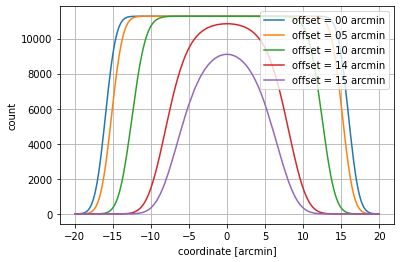

In [7]:
count = {}
x = np.linspace(-20, 20, 1024)
for key, offset in offset_dict.items():
    count[key] = [conv_2d(x, offset, sun, beam) for x in x]

[plt.plot(x, count, label=f"offset = {offset} arcmin") for offset, count in count.items()]
plt.xlabel("coordinate [arcmin]")
plt.ylabel("count")
plt.grid()
plt.legend(loc=1)
# plt.savefig("./sim_observed.pdf")

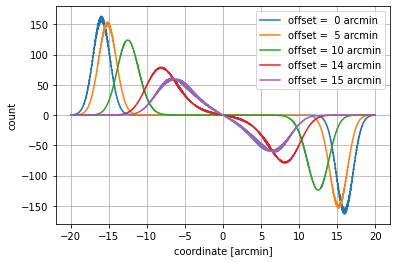

In [8]:
d_count = {}
for key in offset_dict.keys():
    d_count[key] = [count[key][x_count+1] - count[key][x_count] for x_count in range(1023)]
x = np.linspace(-20, 20, 1023)
[plt.plot(x, count, label=f"offset = {offset:2d} arcmin") for offset, count in zip(offset_list, d_count.values())]
plt.xlabel("coordinate [arcmin]")
plt.ylabel("count")
plt.grid()
plt.legend()
# plt.savefig("./sim_derivative.pdf")

In [9]:
def gaussian(x, a, b, c):
    return a * np.exp( - (x - b)**2 / (2 * c**2))

In [10]:
x = np.linspace(-20,0,512)
ini = {}
for key, offset in offset_dict.items():
    ini[key] = (100, -16*np.sqrt(1-offset**2/16**2), 2)
popt, pcov = {}, {}
for key in offset_dict.keys():
    popt[key], pcov[key] = curve_fit(gaussian, x, d_count[key][:512], p0=ini[key])
[print(popt[key], f"for offset = {offset}") for key, offset in offset_dict.items()]

[159.07114709 -15.97781983   1.10668188] for offset = 0
[151.03837063 -15.17551323   1.16524712] for offset = 5
[123.90427709 -12.46999974   1.41730411] for offset = 10
[77.31547116 -7.86755487  2.16928012] for offset = 14
[59.61333901 -6.22831873  2.41700849] for offset = 15


[None, None, None, None, None]

FWHM =  2.6060366647915485 arcmin  for offset = 0 arcmin
FWHM =  2.7439472711143686 arcmin  for offset = 5 arcmin
FWHM =  3.3374961330461437 arcmin  for offset = 10 arcmin
FWHM =  5.108264305374301 arcmin  for offset = 14 arcmin
FWHM =  5.6916200428864006 arcmin  for offset = 15 arcmin


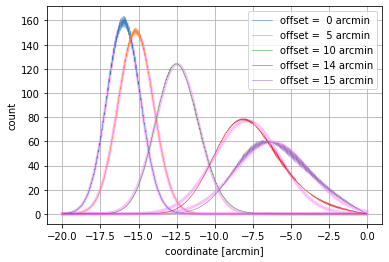

In [11]:
x = np.linspace(-20,0,512)
estimated_curve = {}
for key in offset_dict.keys():
    estimated_curve[key] = gaussian(x, popt[key][0], popt[key][1], popt[key][2])
[plt.plot(x, estimated_curve[key], color=(1, 0.5, 1), lw=3, alpha=0.5) for key in offset_dict.keys()]
[plt.plot(x, d_count[key][:512], lw=0.5, label=f"offset = {offset:2d} arcmin") for key, offset in offset_dict.items()]
plt.xlabel("coordinate [arcmin]")
plt.ylabel("count")
plt.grid()
plt.legend()
[print("FWHM = ", 2*popt[key][2]*np.sqrt(2*np.log(2)), f"arcmin  for offset = {offset} arcmin") for key, offset in offset_dict.items()]
FWHM = {}
for key in offset_dict.keys():
    FWHM[key] = 2*popt[key][2]*np.sqrt(2*np.log(2))
# plt.savefig("./sim_fit.pdf")

$\mathrm{FWHM} \propto t = \dfrac{2.6}{v \cos{\theta}} = \dfrac{2.6}{v \sqrt{1 - \dfrac{\mathrm{offset}^2}{16^2}}}$、$\mathrm{offset} = 16 \sin{\theta}$

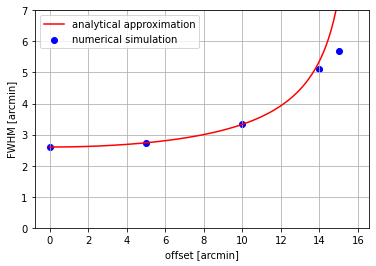

In [12]:
x = np.linspace(0, 15.8, 300)
plt.plot(x, 2.6/np.sqrt(1 - x**2/16**2), "r", label="analytical approximation")
x_ = offset_list
y_ = FWHM.values()
plt.scatter(x_, y_, color="b", label="numerical simulation")
plt.xlabel("offset [arcmin]")
plt.ylabel("FWHM [arcmin]")
plt.ylim([0,7])
plt.grid()
plt.legend()
# plt.savefig("./sim_approx.pdf")